In [7]:
# 1° Step: How the tree was built?
set.seed(1)

rm(list = ls())
install.packages("grf")
install.packages("Hmisc")


  There is a binary version available but the source version is later:
    binary source needs_compilation
grf  1.2.0  2.0.2              TRUE

  Binaries will be installed


Warning message:
"package 'grf' is in use and will not be installed"


  There is a binary version available but the source version is later:
      binary source needs_compilation
Hmisc  4.5-0  4.6-0              TRUE

  Binaries will be installed


Warning message:
"package 'Hmisc' is in use and will not be installed"

In [8]:
library(grf)
if(packageVersion("grf") < '0.10.2') {
  warning("This script requires grf 0.10.2 or higher")}
library(sandwich)
library(lmtest)
library(Hmisc)
library(ggplot2)

In [9]:

data.all = read.csv("synthetic_data.csv")
data.all$schoolid = factor(data.all$schoolid)

In [10]:
DF = data.all[,-1]
school.id = as.numeric(data.all$schoolid)

school.mat = model.matrix(~ schoolid + 0, data = data.all)
school.size = colSums(school.mat)

In [11]:
# It appears that school ID does not affect pscore. So ignore it
# in modeling, and just treat it as source of per-cluster error.
w.lm = glm(Z ~ ., data = data.all[,-3], family = binomial)
summary(w.lm)


Call:
glm(formula = Z ~ ., family = binomial, data = data.all[, -3])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2079  -0.9088  -0.8297   1.4176   1.9556  

Coefficients: (6 not defined because of singularities)
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.9524636  0.2845173  -3.348 0.000815 ***
schoolid2    0.0697302  0.2766287   0.252 0.800986    
schoolid3    0.0382080  0.2911323   0.131 0.895586    
schoolid4    0.1761334  0.2784711   0.633 0.527059    
schoolid5   -0.0033389  0.2950180  -0.011 0.990970    
schoolid6    0.0583548  0.3067481   0.190 0.849124    
schoolid7   -0.1313759  0.3188190  -0.412 0.680288    
schoolid8    0.1233661  0.3023736   0.408 0.683279    
schoolid9   -0.1955428  0.3073344  -0.636 0.524611    
schoolid10  -0.1892794  0.2968750  -0.638 0.523752    
schoolid11  -0.2224060  0.5461005  -0.407 0.683816    
schoolid12  -0.3312420  0.5414374  -0.612 0.540682    
schoolid13  -0.0408540  0.3989507  -0.102 0.9

In [12]:
W = DF$Z
Y = DF$Y
X.raw = DF[,-(1:2)]

In [13]:
C1.exp = model.matrix(~ factor(X.raw$C1) + 0)
XC.exp = model.matrix(~ factor(X.raw$XC) + 0)

X = cbind(X.raw[,-which(names(X.raw) %in% c("C1", "XC"))], C1.exp, XC.exp)

In [14]:
# Grow a forest. Add extra trees for the causal forest.
Y.forest = regression_forest(X, Y, clusters = school.id, equalize.cluster.weights = TRUE)
Y.hat = predict(Y.forest)$predictions
W.forest = regression_forest(X, W, clusters = school.id, equalize.cluster.weights = TRUE)
W.hat = predict(W.forest)$predictions
# The endogenous variable Y is being used (which means according to the Readme ....),
# the X (the covariates ...) and the W (the dummy variable that represents the treatment)

In [15]:
cf.raw = causal_forest(X, Y, W,
                       Y.hat = Y.hat, W.hat = W.hat,
                       clusters = school.id,
                       equalize.cluster.weights = TRUE)
varimp = variable_importance(cf.raw)
selected.idx = which(varimp > mean(varimp))

In [16]:
cf = causal_forest(X[,selected.idx], Y, W,
                   Y.hat = Y.hat, W.hat = W.hat,
                   clusters = school.id,
                   equalize.cluster.weights = TRUE,
                   tune.parameters = "all")
tau.hat = predict(cf)$predictions
# We have built the tree with a machine learning algorithm known as decision tree 
# learning to be able to identify an optimal strategy,
# so we can divide the observed individuals into groups to estimate 
# the heterogeneous effects of the treatment.

In [17]:
# 2° Step: Estimate ATE
ATE = average_treatment_effect(cf)
paste("95% CI for the ATE:", round(ATE[1], 3),
      "+/-", round(qnorm(0.975) * ATE[2], 3))
# The average treatment effect (ATE) that is 0.247
# Has a confidence interval between 0.0210 and 0.286 (+/-0.04) with a 95/% confidence.
# ATE is found through the mean of the distribution of the heterogeneous
# effects distributions that we have found,
# from the sample we have constructed various subgroups, 
# and in each subgroup there is a conditional average treatment effect in each subgroup.

[1] "95% CI for the ATE: 0.247 +/- 0.04"

In [18]:
# 3° Step: Run best linear predictor analysis
test_calibration(cf)



Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction         0.999850   0.082656 12.0966 <2e-16 ***
differential.forest.prediction 0.133496   0.609307  0.2191 0.4133    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [19]:
high_effect = tau.hat > median(tau.hat)
ate.high = average_treatment_effect(cf, subset = high_effect)
ate.low = average_treatment_effect(cf, subset = !high_effect)
paste("95% CI for difference in ATE:",
      round(ate.high[1] - ate.low[1], 3), "+/-",
      round(qnorm(0.975) * sqrt(ate.high[2]^2 + ate.low[2]^2), 3))

[1] "95% CI for difference in ATE: 0.038 +/- 0.073"

In [20]:
# formal test for X1 and X2
dr.score = tau.hat + W / cf$W.hat *
  (Y - cf$Y.hat - (1 - cf$W.hat) * tau.hat) -
  (1 - W) / (1 - cf$W.hat) * (Y - cf$Y.hat + cf$W.hat * tau.hat)
school.score = t(school.mat) %*% dr.score / school.size

In [21]:
school.X1 = t(school.mat) %*% X$X1 / school.size
high.X1 = school.X1 > median(school.X1)
t.test(school.score[high.X1], school.score[!high.X1])


	Welch Two Sample t-test

data:  school.score[high.X1] and school.score[!high.X1]
t = -3.0771, df = 72.115, p-value = 0.002954
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.19481944 -0.04163829
sample estimates:
mean of x mean of y 
0.1882867 0.3065156 


In [22]:
school.X2 = (t(school.mat) %*% X$X2) / school.size
high.X2 = school.X2 > median(school.X2)
t.test(school.score[high.X2], school.score[!high.X2])


	Welch Two Sample t-test

data:  school.score[high.X2] and school.score[!high.X2]
t = 1.0768, df = 71.819, p-value = 0.2852
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.03711945  0.12431855
sample estimates:
mean of x mean of y 
0.2692009 0.2256014 


In [23]:
school.X2.levels = cut(school.X2,
  breaks = c(-Inf, quantile(school.X2, c(1/3, 2/3)), Inf))
summary(aov(school.score ~ school.X2.levels))


                 Df Sum Sq Mean Sq F value Pr(>F)
school.X2.levels  2 0.0884 0.04421   1.433  0.245
Residuals        73 2.2528 0.03086               


	One Sample t-test

data:  school.score.XS3.high - school.score.XS3.low
t = 2.2462, df = 75, p-value = 0.02763
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.009652542 0.160978331
sample estimates:
 mean of x 
0.08531544 


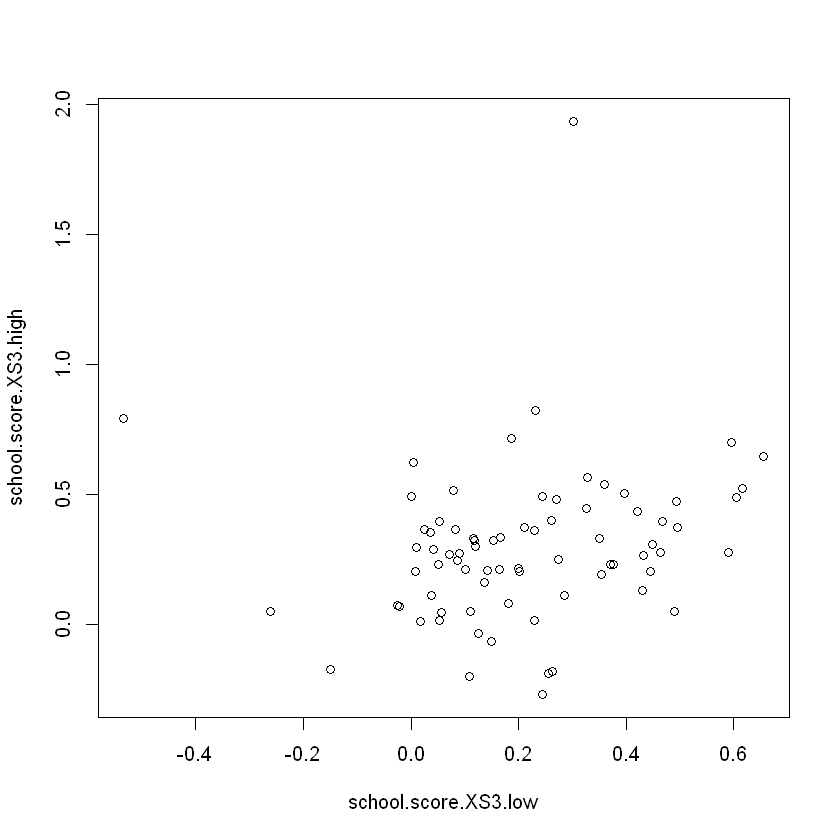

In [48]:
# formal test for S3
school.score.XS3.high = t(school.mat) %*% (dr.score * (X$S3 >= 6)) /
  t(school.mat) %*% (X$S3 >= 6)
school.score.XS3.low = t(school.mat) %*% (dr.score * (X$S3 < 6)) /
  t(school.mat) %*% (X$S3 < 6)

plot(school.score.XS3.low, school.score.XS3.high)
t.test(school.score.XS3.high - school.score.XS3.low)


pdf 
  3

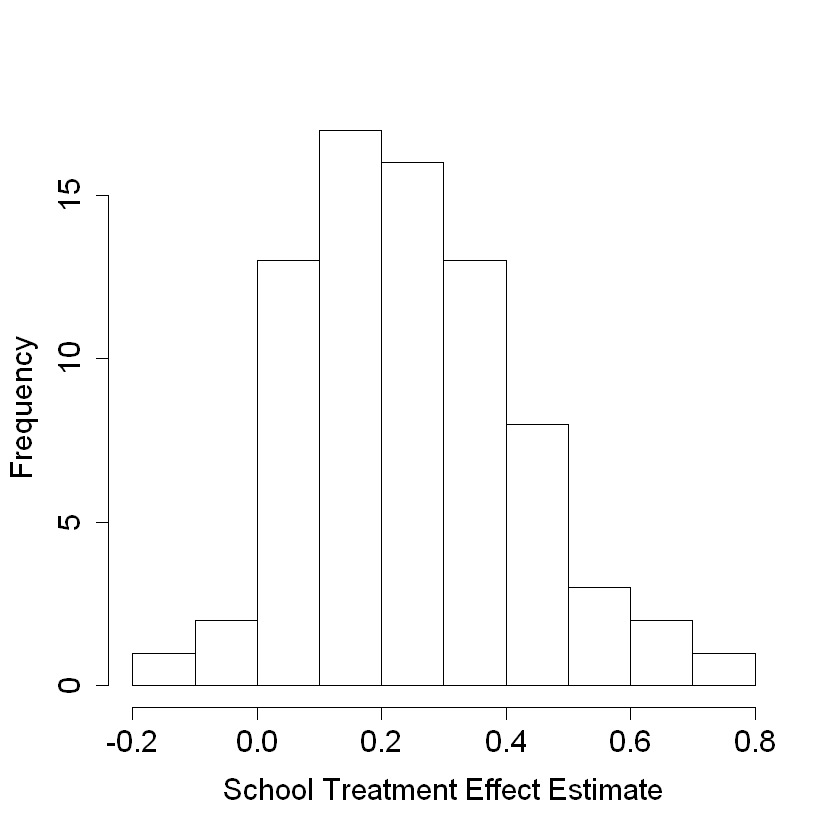

In [49]:
# 4° Step: Look at school-wise heterogeneity

pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(school.score, xlab = "School Treatment Effect Estimate", main = "")
dev.off()
# distribution graph is the distribution of the heterogeneous effects that we have found

In [50]:
# Re-check ATE... sanity check only
ate.hat = mean(school.score)
se.hat = sqrt(var(school.score) / length(school.score - 1))
print(paste(round(ate.hat, 3), "+/-", round(1.96 * se.hat, 3)))

[1] "0.247 +/- 0.04"


In [51]:
# Look at variation in propensity scores
DF = X
DF$W.hat = cf$W.hat

pdf("pscore.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(W.hat ~ S3, data = DF, ylab = "Propensity Score", xlab = "Student Expectation of Success")
lines(smooth.spline(X$S3, cf$W.hat), lwd = 2, col = 4)
dev.off()

png 
  2

In [52]:
# 5° Step: Analysis ignoring clusters. How do the results change?
cf.noclust = causal_forest(X[,selected.idx], Y, W,
                           Y.hat = Y.hat, W.hat = W.hat,
                           tune.parameters = "all")

ATE.noclust = average_treatment_effect(cf.noclust)
paste("95% CI for the ATE:", round(ATE.noclust[1], 3),
      "+/-", round(qnorm(0.975) * ATE.noclust[2], 3))

[1] "95% CI for the ATE: 0.253 +/- 0.022"


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value    Pr(>t)    
mean.forest.prediction         1.009199   0.045041 22.4062 < 2.2e-16 ***
differential.forest.prediction 0.503301   0.122801  4.0985 2.095e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


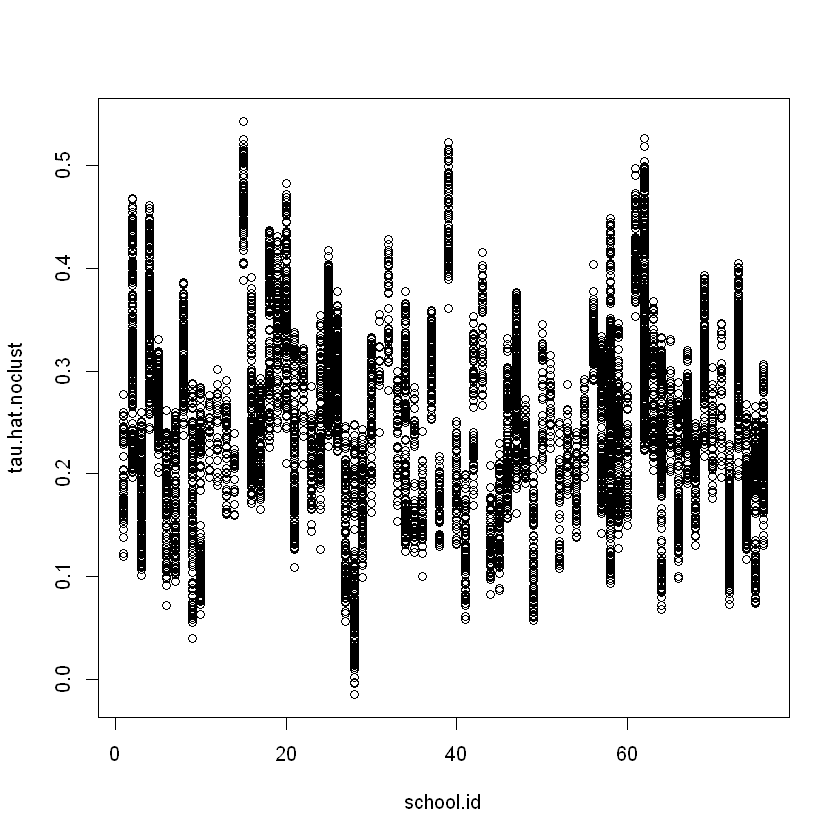

In [53]:
test_calibration(cf.noclust)

tau.hat.noclust = predict(cf.noclust)$predict
plot(school.id, tau.hat.noclust)

In [60]:
nfold = 5
school.levels = unique(school.id)
cluster.folds = sample.int(nfold, length(school.levels), replace = TRUE)

tau.hat.crossfold = rep(NA, length(Y))
for (foldid in 1:nfold) {
  print(foldid)
  infold = school.id %in% school.levels[cluster.folds == foldid]
  cf.fold = causal_forest(X[!infold, selected.idx], Y[!infold], W[!infold],
                          Y.hat = Y.hat[!infold], W.hat = W.hat[!infold],
                          tune.parameters = "all")
  pred.fold = predict(cf.fold, X[infold, selected.idx])$predictions
  tau.hat.crossfold[infold] = pred.fold
}

cf.noclust.cpy = cf.noclust
cf.noclust.cpy$predictions = tau.hat.crossfold
cf.noclust.cpy$clusters = school.id
test_calibration(cf.noclust.cpy)

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5



Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction         0.985665   0.065229 15.1107 <2e-16 ***
differential.forest.prediction 0.209269   0.223759  0.9352 0.1748    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [62]:
install.packages("survival")
install.packages("lattice")
install.packages("ggplot2")
install.packages("Hmisc")

Rloss = mean(((Y - Y.hat) - tau.hat * (W - W.hat))^2)
Rloss.noclust = mean(((Y - Y.hat) - tau.hat.noclust * (W - W.hat))^2)
Rloss.crossfold = mean(((Y - Y.hat) - tau.hat.crossfold * (W - W.hat))^2)

c(Rloss.noclust - Rloss, Rloss.crossfold - Rloss)


  There is a binary version available but the source version is later:
         binary source needs_compilation
survival 3.2-11 3.2-13              TRUE

  Binaries will be installed


Warning message:
"package 'survival' is in use and will not be installed"


  There is a binary version available but the source version is later:
         binary  source needs_compilation
lattice 0.20-44 0.20-45              TRUE

  Binaries will be installed


Warning message:
"package 'lattice' is in use and will not be installed"also installing the dependencies 'isoband', 'rlang'




  There are binary versions available but the source versions are later:
        binary source needs_compilation
isoband  0.2.4  0.2.5              TRUE
rlang   0.4.11 0.4.12              TRUE
ggplot2  3.3.3  3.3.5             FALSE

  Binaries will be installed
package 'isoband' successfully unpacked and MD5 sums checked
package 'rlang' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'rlang'"Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\CARLOS\anaconda3\envs\renv\Lib\R\library\00LOCK\rlang\libs\x64\rlang.dll  a C:\Users\CARLOS\anaconda3\envs\renv\Lib\R\library\rlang\libs\x64\rlang.dll: Permission denied"Warning message:
"restored 'rlang'"


The downloaded binary packages are in
	C:\Users\CARLOS\AppData\Local\Temp\RtmpOwDsxX\downloaded_packages


installing the source package 'ggplot2'

Warning message in install.packages("ggplot2"):
"installation of package 'ggplot2' had non-zero exit status"


  There is a binary version available but the source version is later:
      binary source needs_compilation
Hmisc  4.5-0  4.6-0              TRUE

  Binaries will be installed


Warning message:
"package 'Hmisc' is in use and will not be installed"

[1] -2.789672e-05  4.984980e-04

In [56]:
summary(aov(dr.score ~ factor(school.id)))

                     Df Sum Sq Mean Sq F value   Pr(>F)    
factor(school.id)    75    204   2.719   1.999 7.31e-07 ***
Residuals         10315  14026   1.360                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [63]:
# 6° Step: Analysis without fitting the propensity score
cf.noprop = causal_forest(X[,selected.idx], Y, W,
                          Y.hat = Y.hat, W.hat = mean(W),
                          tune.parameters = "all",
                          equalize.cluster.weights = TRUE,
                          clusters = school.id)
tau.hat.noprop = predict(cf.noprop)$predictions

ATE.noprop = average_treatment_effect(cf.noprop)
paste("95% CI for the ATE:", round(ATE.noprop[1], 3),
      "+/-", round(qnorm(0.975) * ATE.noprop[2], 3))

[1] "95% CI for the ATE: 0.255 +/- 0.04"

In [64]:
pdf("tauhat_noprop.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
plot(tau.hat, tau.hat.noprop,
     xlim = range(tau.hat, tau.hat.noprop),
     ylim = range(tau.hat, tau.hat.noprop),
     xlab = "orthogonalized causal forest estimates",
     ylab = "non-orthogonalized causal forest")
abline(0, 1, lwd = 2, lty = 2, col = 4)
par = pardef

In [36]:
# Train forest on school-wise DR scores
school.X = (t(school.mat) %*% as.matrix(X[,c(4:8, 25:28)])) / school.size
school.X = data.frame(school.X)
colnames(school.X) = c("X1", "X2", "X3", "X4", "X5",
                    "XC.1", "XC.2", "XC.3", "XC.4")

dr.score = tau.hat + W / cf$W.hat * (Y - cf$Y.hat - (1 - cf$W.hat) * tau.hat) -
  (1 - W) / (1 - cf$W.hat) * (Y - cf$Y.hat + cf$W.hat * tau.hat)
school.score = t(school.mat) %*% dr.score / school.size

school.forest = regression_forest(school.X, school.score)
school.pred = predict(school.forest)$predictions
test_calibration(school.forest)


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction         0.996046   0.082429 12.0837 <2e-16 ***
differential.forest.prediction 0.735856   0.647994  1.1356 0.1299    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [65]:
# Alternative OLS analysis
school.DF = data.frame(school.X, school.score=school.score)
coeftest(lm(school.score ~ ., data = school.DF), vcov = vcovHC)


t test of coefficients:

              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.2462869  0.0754265  3.2653 0.001736 **
X1          -0.0503416  0.0293343 -1.7161 0.090828 . 
X2           0.0160023  0.0337751  0.4738 0.637213   
X3           0.0107538  0.0266021  0.4042 0.687340   
X4           0.0241594  0.0256098  0.9434 0.348935   
X5          -0.0355428  0.0266988 -1.3313 0.187686   
XC.1        -0.0052089  0.0914657 -0.0569 0.954758   
XC.2         0.0797300  0.1036885  0.7689 0.444673   
XC.3        -0.1397294  0.0858393 -1.6278 0.108332   
XC.4         0.0381012  0.0811036  0.4698 0.640058   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [72]:
# 7° Step: Six plots and their explanation
pdf("tauhat_hist.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat, xlab = "estimated CATE", main = "")
dev.off()

png 
  2

In [75]:
pdf("tauhat_hist_noprop.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat.noprop, xlab = "estimated CATE", main = "")
dev.off()

png 
  2

In [76]:
pdf("tauhat_hist_noclust.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat.noclust, xlab = "estimated CATE", main = "",
     breaks = seq(-0.0, 0.55, by = 0.55 / 25))
dev.off()

ERROR: Error in hist.default(tau.hat.noclust, xlab = "estimated CATE", main = "", : some 'x' not counted; maybe 'breaks' do not span range of 'x'


In [77]:
pdf("tauhat_vs_X1.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat ~ round(X$X1), xlab = "X1", ylab = "estimated CATE")
lines(smooth.spline(4 + X[,"X1"], tau.hat, df = 4), lwd = 2, col = 4)

In [78]:
pdf("tauhat_vs_X2.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat ~ round(X$X2), xlab = "X2", ylab = "estimated CATE")
lines(smooth.spline(4 + X[,"X2"], tau.hat, df = 4), lwd = 2, col = 4)

In [79]:
school.avg.tauhat = t(school.mat) %*% tau.hat / school.size

In [80]:
pdf("school_avg.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
plot(school.avg.tauhat, school.pred, cex = 1.5,
     xlim = range(school.avg.tauhat, school.pred),
     ylim = range(school.avg.tauhat, school.pred),
     xlab = "average CATE estimate in school",
     ylab = "school-wise forest predictions")
abline(0, 1, lwd = 2, lty = 2, col = 4)
par = pardef

In [81]:
# Experiment with no orthogonalization
n.synth = 1000
p.synth = 10
X.synth = matrix(rnorm(n.synth * p.synth), n.synth, p.synth)
W.synth = rbinom(n.synth, 1, 1 / (1 + exp(-X.synth[,1])))
Y.synth = 2 * rowMeans(X.synth[,1:6]) + rnorm(n.synth)

Y.forest.synth = regression_forest(X.synth, Y.synth)
Y.hat.synth = predict(Y.forest.synth)$predictions
W.forest.synth = regression_forest(X.synth, W.synth)
W.hat.synth = predict(W.forest.synth)$predictions

cf.synth = causal_forest(X.synth, Y.synth, W.synth,
                         Y.hat = Y.hat.synth, W.hat = W.hat.synth)
ATE.synth = average_treatment_effect(cf.synth)
paste("95% CI for the ATE:", round(ATE.synth[1], 3),
      "+/-", round(qnorm(0.975) * ATE.synth[2], 3))

cf.synth.noprop = causal_forest(X.synth, Y.synth, W.synth,
                                Y.hat = Y.hat.synth, W.hat = mean(W.synth))
ATE.synth.noprop = average_treatment_effect(cf.synth.noprop)
paste("95% CI for the ATE:", round(ATE.synth.noprop[1], 3),
      "+/-", round(qnorm(0.975) * ATE.synth.noprop[2], 3))

[1] "95% CI for the ATE: 0.099 +/- 0.149"

[1] "95% CI for the ATE: 0.194 +/- 0.136"

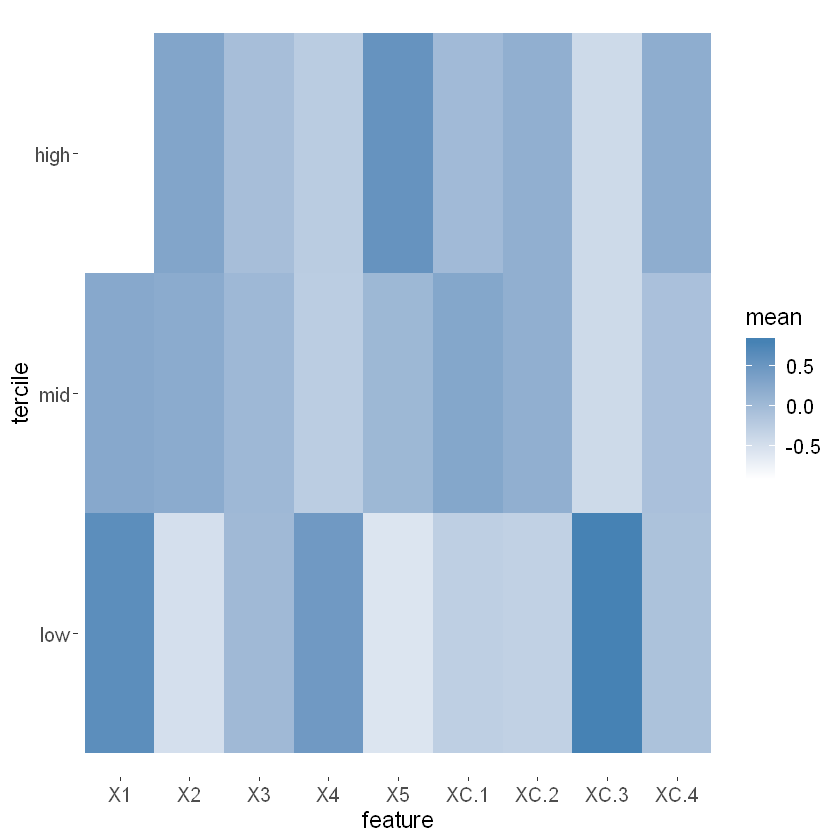

In [82]:
#Step 8: Visualize school-level covariates by treatment heterogeneity
school.X.std = scale(school.X)
school.tercile = cut(school.pred,
                     breaks = c(-Inf, quantile(school.pred, c(1/3, 2/3)), Inf))
school.tercile.mat = model.matrix(~ school.tercile + 0)
school.means = diag(1 / colSums(school.tercile.mat)) %*% t(school.tercile.mat) %*% as.matrix(school.X.std)

MM = max(abs(school.means))
HC = heat.colors(21)
school.col = apply(school.means, 1:2, function(aa) HC[1 + round(20 * (0.5 + aa))])

DF.plot = data.frame(tercile=rep(factor(1:3, labels=c("low", "mid", "high")), 9), mean=as.numeric(school.means),
                     feature = factor(rbind(colnames(school.X), colnames(school.X), colnames(school.X))))

ggplot(data = DF.plot, aes(x = feature, y = tercile, fill = mean)) +
    geom_tile() + scale_fill_gradient(low = "white", high = "steelblue") +
    theme(axis.text = element_text(size=12), axis.title = element_text(size=14),
          legend.title = element_text(size=14), legend.text = element_text(size=12)) +
    theme(panel.background = element_blank())
ggsave("tercile_plot.pdf", width = 8, height = 4.5, dpi = 120)

In [83]:
mean(school.X$XC.3)
mean(school.X$XC.3[as.numeric(school.tercile) == 1])


[1] 0.2105263

[1] 0.5384615

In [84]:
# 9° Step: CATE by school
ord = order(order(school.pred))
school.sort = ord[school.id]

pdf("school_boxplot.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat.noclust ~ school.sort, xaxt = "n",
        xlab = "school", ylab = "estimated CATE")
points(1:76, sort(school.pred), col = 4, pch = 16)
legend("topleft", c("school mean CATE", "CATE w/o clustering"), pch = c(16, 1), col = c(4, 1), cex = 1.5)
par = pardef
dev.off()

png 
  2

In [72]:
## pregunta 2 DML

# Testing the Convergence Hypothesis

## Introduction

We provide an additional empirical example of partialling-out with Lasso to estimate the regression coefficient $\beta_1$ in the high-dimensional linear regression model:
  $$
  Y = \beta_1 D +  \beta_2'Z + \epsilon.
  $$
  
Specifically, we are interested in how the rates  at which economies of different countries grow ($Y$) are related to the initial wealth levels in each country ($D$) controlling for country's institutional, educational, and other similar characteristics ($Z$).
  
The relationship is captured by $\beta_1$, the *speed of convergence/divergence*, which measures the speed at which poor countries catch up $(\beta_1< 0)$ or fall behind $(\beta_1> 0)$ rich countries, after controlling for $Z$. Our inference question here is: do poor countries grow faster than rich countries, controlling for educational and other characteristics? In other words, is the speed of convergence negative: $ \beta_1 <0?$ This is the Convergence Hypothesis predicted by the Solow Growth Model. This is a structural economic model. Under some strong assumptions, that we won't state here, the predictive exercise we are doing here can be given causal interpretation.


The outcome $Y$ is the realized annual growth rate of a country's wealth  (Gross Domestic Product per capita). The target regressor ($D$) is the initial level of the country's wealth. The target parameter $\beta_1$ is the speed of convergence, which measures the speed at which poor countries catch up with rich countries. The controls ($Z$) include measures of education levels, quality of institutions, trade openness, and political stability in the country.

## Data

We consider the data set GrowthData which is included in the package *hdm*. First, let us load the data set to get familiar with the data.

In [27]:
library(hdm)
library(xtable)

In [28]:
data <- GrowthData
attach(data)
names(data)

The following objects are masked from data (pos = 8):

    bmp1l, ex1, fert1, fert65, freeop, freetar, gde1, gdpsh465,
    geerec1, geetot1, govsh41, govwb1, gpop1, gvxdxe41, h65, hf65,
    high65, highc65, highcf65, highcm65, highf65, highm65, hm65,
    human65, humanf65, humanm65, hyr65, hyrf65, hyrm65, im1, intercept,
    invsh41, lifee065, mort1, mort65, no65, nof65, nom65, Outcome, p65,
    pf65, pinstab1, pm65, pop1565, pop65, pop6565, s65, sec65, secc65,
    seccf65, seccm65, secf65, secm65, sf65, sm65, syr65, syrf65,
    syrm65, teapri65, teasec65, tot1, worker65, xr65



[1] "Outcome"   "intercept" "gdpsh465"  "bmp1l"     "freeop"    "freetar"  
 [7] "h65"       "hm65"      "hf65"      "p65"       "pm65"      "pf65"     
[13] "s65"       "sm65"      "sf65"      "fert65"    "mort65"    "lifee065" 
[19] "gpop1"     "fert1"     "mort1"     "invsh41"   "geetot1"   "geerec1"  
[25] "gde1"      "govwb1"    "govsh41"   "gvxdxe41"  "high65"    "highm65"  
[31] "highf65"   "highc65"   "highcm65"  "highcf65"  "human65"   "humanm65" 
[37] "humanf65"  "hyr65"     "hyrm65"    "hyrf65"    "no65"      "nom65"    
[43] "nof65"     "pinstab1"  "pop65"     "worker65"  "pop1565"   "pop6565"  
[49] "sec65"     "secm65"    "secf65"    "secc65"    "seccm65"   "seccf65"  
[55] "syr65"     "syrm65"    "syrf65"    "teapri65"  "teasec65"  "ex1"      
[61] "im1"       "xr65"      "tot1"

In [29]:
head(data)

Outcome,intercept,gdpsh465,bmp1l,freeop,freetar,h65,hm65,hf65,p65,...,seccf65,syr65,syrm65,syrf65,teapri65,teasec65,ex1,im1,xr65,tot1
-0.02433575,1,6.591674,0.2837,0.153491,0.043888,0.007,0.013,0.001,0.29,...,0.04,0.033,0.057,0.010,47.6,17.3,0.0729,0.0667,0.348,-0.014727
0.10047257,1,6.829794,0.6141,0.313509,0.061827,0.019,0.032,0.007,0.91,...,0.64,0.173,0.274,0.067,57.1,18.0,0.0940,0.1438,0.525,0.005750
0.06705148,1,8.895082,0.0000,0.204244,0.009186,0.260,0.325,0.201,1.00,...,18.14,2.573,2.478,2.667,26.5,20.7,0.1741,0.1750,1.082,-0.010040
0.06408917,1,7.565275,0.1997,0.248714,0.036270,0.061,0.070,0.051,1.00,...,2.63,0.438,0.453,0.424,27.8,22.7,0.1265,0.1496,6.625,-0.002195
0.02792955,1,7.162397,0.1740,0.299252,0.037367,0.017,0.027,0.007,0.82,...,2.11,0.257,0.287,0.229,34.5,17.6,0.1211,0.1308,2.500,0.003283
0.04640744,1,7.218910,0.0000,0.258865,0.020880,0.023,0.038,0.006,0.50,...,1.46,0.160,0.174,0.146,34.3,8.1,0.0634,0.0762,1.000,-0.001747


In [30]:
dim(data)

[1] 90 63

### Preprocessing

To account for heterogeneity across counties and time trends in  all variables, we remove from them county-specific and time-specific effects in the following preprocessing.

Now, we can construct the treatment variable, the outcome variable and the matrix $Z$ that includes the control variables.

In [33]:
# Treatment Variable
D <- data["gdpsh465"]
# Outcome Variable
Y <- data["Outcome"]

# Construct matrix Z
Z <- data[,c(2,4:63)]

We have in total 60 control variables.

In [41]:
# install.packages("lfe")

also installing the dependency 'sandwich'




  There are binary versions available but the source versions are later:
         binary  source needs_compilation
sandwich  3.0-0   3.0-1             FALSE
lfe       2.8-6 2.8-7.1              TRUE

  Binaries will be installed
package 'lfe' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\User\AppData\Local\Temp\RtmpQ7jWpI\downloaded_packages


installing the source package 'sandwich'



In [35]:
library(lfe)

## The effect of gun ownership

### OLS

After preprocessing the data, we first look at simple regression of $Y_{j,t}$ on $D_{j,t-1}$ without controls as a baseline model.

In [36]:
#baseline_formula <- as.formula(paste(y, "~", d ))
#baseline.ols <- lm(baseline_formula,data=rdata)

baseline.ols <- felm(Outcome ~ gdpsh465,data=data) 
est_baseline <- summary(baseline.ols)$coef[2,]
confint(baseline.ols)[2,]
est_baseline

2.5 %      97.5 % 
-0.01081013  0.01344355

Estimate  Std. Error     t value    Pr(>|t|) 
0.001316713 0.006102200 0.215776701 0.829661165

In [37]:
summary(baseline.ols)


Call:
   felm(formula = Outcome ~ gdpsh465, data = data) 

Residuals:
      Min        1Q    Median        3Q       Max 
-0.147387 -0.024088  0.001209  0.027721  0.139357 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) 0.035207   0.047318   0.744    0.459
gdpsh465    0.001317   0.006102   0.216    0.830

Residual standard error: 0.05159 on 88 degrees of freedom
Multiple R-squared(full model): 0.0005288   Adjusted R-squared: -0.01083 
Multiple R-squared(proj model): 0.0005288   Adjusted R-squared: -0.01083 
F-statistic(full model):0.04656 on 1 and 88 DF, p-value: 0.8297 
F-statistic(proj model): 0.04656 on 1 and 88 DF, p-value: 0.8297 



In [38]:
confint(baseline.ols)[2,]

2.5 %      97.5 % 
-0.01081013  0.01344355

The point estimate is $0.0013$ with the confidence interval ranging from -0.011 to 0.013. If initial wealth increases by 1% relative to a trend then the predicted growth rate goes up by 0.13%, without controlling for counties' characteristics.

Since our goal is to estimate the effect of gun ownership after controlling for a rich set county characteristics we next include the controls. First, we estimate the model by ols and then by an array of the modern regression methods using the double machine learning approach.

In [39]:
control_formula <- as.formula(paste("Outcome", "~", paste("gdpsh465",paste(colnames(Z),collapse="+"),
                                                          sep="+")))
control_formula

Outcome ~ gdpsh465 + intercept + bmp1l + freeop + freetar + h65 + 
    hm65 + hf65 + p65 + pm65 + pf65 + s65 + sm65 + sf65 + fert65 + 
    mort65 + lifee065 + gpop1 + fert1 + mort1 + invsh41 + geetot1 + 
    geerec1 + gde1 + govwb1 + govsh41 + gvxdxe41 + high65 + highm65 + 
    highf65 + highc65 + highcm65 + highcf65 + human65 + humanm65 + 
    humanf65 + hyr65 + hyrm65 + hyrf65 + no65 + nom65 + nof65 + 
    pinstab1 + pop65 + worker65 + pop1565 + pop6565 + sec65 + 
    secm65 + secf65 + secc65 + seccm65 + seccf65 + syr65 + syrm65 + 
    syrf65 + teapri65 + teasec65 + ex1 + im1 + xr65 + tot1

In [40]:
control.ols <- felm(control_formula,data=data)
est_ols <- summary(control.ols)$coef[2,]
confint(control.ols)[2,]
est_ols

Warning message in chol.default(mat, pivot = TRUE, tol = tol):
"the matrix is either rank-deficient or indefinite"Warning message in chol.default(mat, pivot = TRUE, tol = tol):
"the matrix is either rank-deficient or indefinite"

2.5 %      97.5 % 
-0.07060022  0.05184424

Estimate   Std. Error      t value     Pr(>|t|) 
-0.009377989  0.029887726 -0.313773909  0.756018519

In [81]:
summary(control.ols)$coef

Warning message in chol.default(mat, pivot = TRUE, tol = tol):
"the matrix is either rank-deficient or indefinite"

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.247160892,0.78450164,0.31505465,0.755056171
gdpsh465,-0.009377989,0.02988773,-0.31377391,0.756018519
intercept,NaN,NA,NaN,NaN
bmp1l,-0.068862679,0.03253065,-2.11685514,0.043289717
freeop,0.080068972,0.20786400,0.38519884,0.703000843
freetar,-0.488962603,0.41816285,-1.16931143,0.252136478
h65,-2.362098643,0.85729167,-2.75530339,0.010192435
hm65,0.707143403,0.52314511,1.35171561,0.187285917
hf65,1.693448426,0.50318881,3.36543337,0.002232683
p65,0.265526696,0.16429407,1.61616729,0.117271228


After controlling for a rich set of characteristics, the point estimate of gun ownership reduces to -$0.009$.

# DML algorithm

Here we perform inference of the predictive coefficient $\beta$ in our partially linear statistical model, 

$$
Y = D\beta + g(Z) + \epsilon, \quad E (\epsilon | D, Z) = 0,
$$

using the **double machine learning** approach. 

For $\tilde Y = Y- E(Y|Z)$ and $\tilde D= D- E(D|Z)$, we can write
$$
\tilde Y = \alpha \tilde D + \epsilon, \quad E (\epsilon |\tilde D) =0.
$$

Using cross-fitting, we employ modern regression methods
to build estimators $\hat \ell(Z)$ and $\hat m(Z)$ of $\ell(Z):=E(Y|Z)$ and $m(Z):=E(D|Z)$ to obtain the estimates of the residualized quantities:

$$
\tilde Y_i = Y_i  - \hat \ell (Z_i),   \quad \tilde D_i = D_i - \hat m(Z_i), \quad \text{ for each } i = 1,\dots,n.
$$

Finally, using ordinary least squares of $\tilde Y_i$ on $\tilde D_i$, we obtain the 
estimate of $\beta$.

The following algorithm comsumes $Y, D, Z$, and a machine learning method for learning the residuals $\tilde Y$ and $\tilde D$, where the residuals are obtained by cross-validation (cross-fitting). Then, it prints the estimated coefficient $\beta$ and the corresponding standard error from the final OLS regression.

In [55]:
DML2.for.PLM <- function(z, d, y, dreg, yreg, nfold=2) {
  nobs <- nrow(z) #number of observations
  foldid <- rep.int(1:nfold,times = ceiling(nobs/nfold))[sample.int(nobs)] #define folds indices
  I <- split(1:nobs, foldid)  #split observation indices into folds  
  ytil <- dtil <- rep(NA, nobs)
  cat("fold: ")
  for(b in 1:length(I)){
    dfit <- dreg(z[-I[[b]],], d[-I[[b]]]) #take a fold out
    yfit <- yreg(z[-I[[b]],], y[-I[[b]]]) # take a foldt out
    dhat <- predict(dfit, z[I[[b]],], type="response") #predict the left-out fold 
    yhat <- predict(yfit, z[I[[b]],], type="response") #predict the left-out fold  
    dtil[I[[b]]] <- (d[I[[b]]] - dhat) #record residual for the left-out fold
    ytil[I[[b]]] <- (y[I[[b]]] - yhat) #record residial for the left-out fold
    cat(b," ")
        }
  #rfit <- lm(ytil ~ dtil)    #estimate the main parameter by regressing one residual on the other
  data <- data.frame(cbind(ytil, dtil))
  rfit <- felm(ytil ~ dtil,data=data) 
  coef.est <- coef(rfit)[2]  #extract coefficient
  #HC <- vcovHC(rfit)
  se    <- summary(rfit,robust=T)$coefficients[2,2] #record robust standard error by County
  cat(sprintf("\ncoef (se) = %g (%g)\n", coef.est , se))  #printing output
  return( list(coef.est =coef.est , se=se, dtil=dtil, ytil=ytil, rfit=rfit) ) #save output and residuals 
}

Now, we apply the Double Machine Learning (DML) approach with different machine learning methods. First, we load the relevant libraries.

In [42]:
library(hdm)
library(glmnet)
library(sandwich)
library(randomForest)

Let us, construct the input matrices.

In [43]:
y <- as.matrix(Y)
d <- as.matrix(D)
z <- as.matrix(Z)
head(data.frame(cbind(y,d)))

Outcome,gdpsh465
-0.02433575,6.591674
0.10047257,6.829794
0.06705148,8.895082
0.06408917,7.565275
0.02792955,7.162397
0.04640744,7.218910


In the following, we apply the DML approach with the differnt versions of lasso.


## Lasso

In [56]:
#DML with Lasso:
set.seed(123)
dreg <- function(z,d){ rlasso(z,d, post=FALSE) } #ML method= lasso from hdm 
yreg <- function(z,y){ rlasso(z,y, post=FALSE) } #ML method = lasso from hdm

In [57]:
DML2.lasso = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.0369952 (0.0161759)


In [58]:
#DML with Post-Lasso:
dreg <- function(z,d){ rlasso(z,d, post=T) } #ML method= lasso from hdm 
yreg <- function(z,y){ rlasso(z,y, post=T) } #ML method = lasso from hdm
DML2.post = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.0368285 (0.0141174)


In [60]:
#DML with cross-validated Lasso:
dreg <- function(z,d){ cv.glmnet(z,d,family="gaussian", alpha=1) }#ML method = lasso from glmnet 
yreg <- function(z,y){ cv.glmnet(z,y,family="gaussian", alpha=1) }  #ML method = lasso from glmnet 
DML2.lasso.cv = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

dreg <- function(z,d){ cv.glmnet(z,d,family="gaussian", alpha=0.5) } #ML method = elastic net from glmnet 
yreg <- function(z,y){ cv.glmnet(z,y,family="gaussian", alpha=0.5) }  #ML method = elastic net from glmnet 
DML2.elnet = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

dreg <- function(z,d){ cv.glmnet(z,d,family="gaussian", alpha=0) } #ML method = ridge from glmnet 
yreg <- function(z,y){ cv.glmnet(z,y,family="gaussian", alpha=0) }  #ML method = ridge from glmnet 
DML2.ridge = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.034646 (0.015148)
fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.0327301 (0.0169996)
fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.032822 (0.0166835)


Here we also compute DML with OLS used as the ML method

In [61]:
dreg <- function(z,d){  glmnet(z,d,family="gaussian", lambda=0) } #ML method = ols from glmnet 
yreg <- function(z,y){  glmnet(z,y,family="gaussian", lambda=0) }  #ML method = ols from glmnet 
DML2.ols = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = 0.0182241 (0.0178608)


Next, we also apply Random Forest for comparison purposes.

### Random Forest


In [62]:
#DML with Random Forest:
dreg <- function(z,d){ randomForest(z, d) } #ML method=Forest 
yreg <- function(z,y){ randomForest(z, y) } #ML method=Forest
set.seed(1)
DML2.RF = DML2.for.PLM(z, d, y, dreg, yreg, nfold=2) # set to 2 due to computation time

fold: 1  2  
coef (se) = -0.0298748 (0.0130213)


In [63]:
if (!is.null(d) && !is.factor(d))
             max(floor(ncol(z)/3), 1) else floor(sqrt(ncol(z)))

[1] 20

In [64]:
if (!is.null(d) && !is.factor(d)) 5 else 1

[1] 5

We conclude that the initial wealth levels are related to groeth rates - if initial wealth levels increases by 1% relative
to a trend then the predicted growth rate goes down by about -2.9% controlling for countries' characteristics.

Finally, let's see which method is actually better. We compute RMSE for predicting D and Y, and see which
of the methods works better.


In [65]:
mods<- list(DML2.ols, DML2.lasso, DML2.post, DML2.lasso.cv, DML2.ridge, DML2.elnet, DML2.RF)

RMSE.mdl<- function(mdl) {
RMSEY <- sqrt(mean(mdl$ytil)^2) 
RMSED <- sqrt(mean(mdl$dtil)^2) 
return( list(RMSEY=RMSEY, RMSED=RMSED))
}

#RMSE.mdl(DML2.lasso)

#DML2.lasso$ytil

Res<- lapply(mods, RMSE.mdl)


prRes.Y<- c( Res[[1]]$RMSEY,Res[[2]]$RMSEY, Res[[3]]$RMSEY, Res[[4]]$RMSEY, Res[[5]]$RMSEY,  Res[[6]]$RMSEY, Res[[7]]$RMSEY)
prRes.D<- c( Res[[1]]$RMSED,Res[[2]]$RMSED, Res[[3]]$RMSED, Res[[4]]$RMSED, Res[[5]]$RMSED, Res[[6]]$RMSED, Res[[7]]$RMSED)

prRes<- rbind(prRes.Y, prRes.D); 
rownames(prRes)<- c("RMSE D", "RMSE Y");
colnames(prRes)<- c("OLS", "Lasso", "Post-Lasso", "CV Lasso", "CV Ridge", "CV Elnet", "RF")
print(prRes,digit=6)

              OLS       Lasso  Post-Lasso    CV Lasso    CV Ridge   CV Elnet
RMSE D 0.00403776 0.000826522 0.000333837 0.000436594 3.50298e-05 0.00164062
RMSE Y 0.01183033 0.012439662 0.000541272 0.016454812 1.31240e-03 0.00108917
               RF
RMSE D 0.00105521
RMSE Y 0.03301785


It looks like the best method for predicting D is CV Ridge, and the best method for predicting Y is Post-Lasso.


In [66]:
dreg <- function(z,d){ cv.glmnet(z,d,family="gaussian", alpha=0) } #ML method = ridge from glmnet  
yreg <- function(z,y){ rlasso(z,y, post=T) } #ML method = lasso from hdm
DML2.best= DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.0425124 (0.0156761)


Let's organize the results in a table.

In [68]:
est_baseline

Estimate  Std. Error     t value    Pr(>|t|) 
0.001316713 0.006102200 0.215776701 0.829661165

In [69]:
library(xtable)

table <- matrix(0,9,2)
table[1,1] <- as.numeric(est_baseline[1])
table[2,1] <- as.numeric(est_ols[1])
table[3,1]   <- as.numeric(DML2.lasso$coef.est)
table[4,1]   <- as.numeric(DML2.post$coef.est)
table[5,1]  <-as.numeric(DML2.lasso.cv$coef.est)
table[6,1] <-as.numeric(DML2.elnet$coef.est)
table[7,1] <-as.numeric(DML2.ridge$coef.est)
table[8,1] <-as.numeric(DML2.RF$coef.est)
table[9,1] <-as.numeric(DML2.best$coef.est)
table[1,2] <- as.numeric(est_baseline[2])
table[2,2] <- as.numeric(est_ols[2])
table[3,2]   <- as.numeric(DML2.lasso$se)
table[4,2]   <- as.numeric(DML2.post$se)
table[5,2]  <-as.numeric(DML2.lasso.cv$se)
table[6,2] <-as.numeric(DML2.elnet$se)
table[7,2] <-as.numeric(DML2.ridge$se)
table[8,2] <-as.numeric(DML2.RF$se)
table[9,2] <-as.numeric(DML2.best$se)




################################# Print Results #################################

colnames(table) <- c("Estimate","Standard Error")
rownames(table) <- c("Baseline OLS", "Least Squares with controls", "Lasso", "Post-Lasso", "CV Lasso","CV Elnet", "CV Ridge", "Random Forest", 
                     "Best")

table

,Estimate,Standard Error
Baseline OLS,0.001316713,0.00610220
Least Squares with controls,-0.009377989,0.02988773
Lasso,-0.036995153,0.01617587
Post-Lasso,-0.036828539,0.01411740
CV Lasso,-0.034646049,0.01514796
CV Elnet,-0.032730133,0.01699957
CV Ridge,-0.032821972,0.01668353
Random Forest,-0.029874780,0.01302127
Best,-0.042512406,0.01567607


In [70]:
print(table, digit=3)


                            Estimate Standard Error
Baseline OLS                 0.00132         0.0061
Least Squares with controls -0.00938         0.0299
Lasso                       -0.03700         0.0162
Post-Lasso                  -0.03683         0.0141
CV Lasso                    -0.03465         0.0151
CV Elnet                    -0.03273         0.0170
CV Ridge                    -0.03282         0.0167
Random Forest               -0.02987         0.0130
Best                        -0.04251         0.0157


In [71]:
tab<- xtable(table, digits=3)
print(tab, type="latex")

% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sat Nov 27 20:32:43 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & Estimate & Standard Error \\ 
  \hline
Baseline OLS & 0.001 & 0.006 \\ 
  Least Squares with controls & -0.009 & 0.030 \\ 
  Lasso & -0.037 & 0.016 \\ 
  Post-Lasso & -0.037 & 0.014 \\ 
  CV Lasso & -0.035 & 0.015 \\ 
  CV Elnet & -0.033 & 0.017 \\ 
  CV Ridge & -0.033 & 0.017 \\ 
  Random Forest & -0.030 & 0.013 \\ 
  Best & -0.043 & 0.016 \\ 
   \hline
\end{tabular}
\end{table}
